## Outline
---

1. Edge detection
2. Find Connected Components, remove small components
3. Remove components that are connected to the border

2 Approach
1. Bounding Box
- Find the min/max of x and y coordinates of the components
- Draw a rectangle around the component

2. Segmentation
- Find extreme points of the component
- Connect the extreme points to form a polygon
- Fill the polygon

In [1]:
import matplotlib.pyplot as plt
from image_util import I

## Filters
---


forward difference: $ f'(x) = \frac{f(x+h) - f(x)}{h}$

backward difference: $ f'(x) = \frac{f(x) - f(x-h)}{h}$

central difference: $f'(x)=\frac{f(x+h) - f(x-h)}{2h}$

### Padding

In [2]:
import copy

def pad_image(image, padding_height, padding_width):
    image = copy.deepcopy(image) # Avoid modifying the original image
    padded_image = []
    rows = len(image)
    cols = len(image[0])
    channels = len(image[0][0]) if type(image[0][0]) == list else 1 

    # Adjust channels
    zeros = [0] * channels
    if (channels == 1):
        zeros = 0

    # Pad rows at the top and bottom
    for i in range(padding_height):
        padded_image.append([zeros] * cols)
    for row in image:
        padded_image.append(row)
    for i in range(padding_height):
        padded_image.append([zeros] * cols)

    # Pad columns at the left and right
    for i in range(len(padded_image)):
        for j in range(padding_width):
            padded_image[i].insert(0, zeros)
        for j in range(padding_width):
            padded_image[i].append(zeros)

    return copy.deepcopy(padded_image)

### Convolution

In [3]:
import copy

def convolution(image, kernel):
    '''
    Performs convolution between an image and a kernel
    '''
    image = copy.deepcopy(image) # Avoid modifying the original image
    
    padding_height = len(kernel) // 2
    padding_width = len(kernel[0]) // 2
    
    # Pad the image
    padded_image = pad_image(image, padding_height, padding_width)
    
    # Create an output matrix with the same dimensions as the input image
    output = [[0] * len(image[0]) for i in range(len(image))]

    # Perform convolution
    image_height = len(image)
    image_width = len(image[0])
    kernel_height = len(kernel)
    kernel_width = len(kernel[0])
    
    for i in range(image_height):
        for j in range(image_width):
            for k in range(kernel_height):
                for l in range(kernel_width):
                    # kernel multiplication
                    if type(padded_image[i + k][j + l]) == list:
                        result = [x * kernel[k][l] for x in padded_image[i + k][j + l]]
                    else: # Assume it's a number
                        result = padded_image[i + k][j + l] * kernel[k][l]
                    output[i][j] = output[i][j] + int(result)
    return output

### Edge detection

In [4]:
from canny_operator import canny_edge_detector

In [5]:
def edge_detection(
    img: list,
    x_kernel: list = [[-1, 0, 1], 
                     [-2, 0, 2], 
                     [-1, 0, 1]],
    y_kernel: list = [[-1, -2, -1],
                      [0, 0, 0],
                      [1, 2, 1]]
    ) -> list:
    '''
    detect edges in an image
    '''
    # convert image to grayscale
    if type(img[0][0]) != int and len(img[0][0]) == 3:
        img = I.to_gray(img)
    
    # create edge image
    edge = []
       
    # calculate the gradient in the x-direction and y-direction
    Ix = convolution(img, x_kernel)
    Iy = convolution(img, y_kernel)
        
    # loop through the image
    for i in range(len(img)):
        edge.append([])
        for j in range(len(img[0])):
            # remove edge pixels in image boundary
            if i == 0 or i == len(img) - 1 or j == 0 or j == len(img[0]) - 1:
                edge[i].append([0])
                continue
            # calculate the gradient magnitude
            edge[i].append([int((Ix[i][j]**2 + Iy[i][j]**2)**0.5)])
            
    return edge

In [6]:
def edge_threshold(edge: list, threshold: int = 100) -> list:
    '''
    threshold the edge image
    '''
    # create a copy of the edge image
    edge = copy.deepcopy(edge)
    
    # loop through the image
    for i in range(len(edge)):
        for j in range(len(edge[0])):
            # threshold the pixel
            if edge[i][j][0] > threshold:
                edge[i][j] = 255
            else:
                edge[i][j] = 0
                
    return edge

### Median Filter

In [7]:
def median_filter(gray_img, mask=3):
    """
    :param gray_img: gray image
    :param mask: mask size
    :return: image with median filter
    """
    # set image borders
    bd = int(mask / 2)
    
    row = len(gray_img)
    col = len(gray_img[0])
    
    # copy image size
    median_img = [[0] * col for i in range(row)]
    
    for i in range(bd, row - bd):
        for j in range(bd, col - bd):
            # get mask according with mask
            kernel = [[gray_img[i - bd + k][j - bd + l] for l in range(mask)] for k in range(mask)]
            kernel = I.flatten(kernel)
            sorted_list = sorted(kernel)
            # calculate mask median
            median = sorted_list[int(len(sorted_list) / 2)]
            median_img[i][j] = median
    return median_img

### Gaussian Filter

In [8]:
import math

def generate_gaussian_kernel(size, sigma):
    kernel = [[0.0] * size for _ in range(size)]
    center = size // 2
    total = 0.0

    for i in range(size):
        for j in range(size):
            x = i - center
            y = j - center
            exponent = -(x ** 2 + y ** 2) / (2 * sigma ** 2)
            kernel[i][j] = math.exp(exponent)
            total += kernel[i][j]

    # Normalize the kernel
    for i in range(size):
        for j in range(size):
            kernel[i][j] /= total
            kernel[i][j] = round(kernel[i][j], 2)

    return kernel

In [9]:
gaussian_kernel = generate_gaussian_kernel(5, 2)
gaussian_kernel

[[0.02, 0.03, 0.04, 0.03, 0.02],
 [0.03, 0.05, 0.06, 0.05, 0.03],
 [0.04, 0.06, 0.06, 0.06, 0.04],
 [0.03, 0.05, 0.06, 0.05, 0.03],
 [0.02, 0.03, 0.04, 0.03, 0.02]]

### Find Connected Components

In [10]:
import copy

def connected_components(binary_image, min_size=100):
    '''
    Find and label connected components in a binary image
    input: binary image (2D array)
    output: labeled image (2D array), dictionary of component sizes, number of components
    '''
    binary_image = copy.deepcopy(binary_image) # Make sure we don't overwrite the original image
    height, width = len(binary_image), len(binary_image[0])
    label_matrix = [[0] * width for _ in range(height)]  # Initialize empty label matrix

    label = 0  # Start label
    label_dict = {}  # Keep track of which label corresponds to which connected component
    component_sizes = {}  # Keep track of component sizes
    
    # First pass
    for i in range(height):
        for j in range(width):            
            if binary_image[i][j] == 0: # background pixel
                continue
            
            if i == 0 and j == 0: # first pixel
                continue
            try:
                # check neighbors (8-connectivity)
                neighbors = [binary_image[i][j-1], 
                            binary_image[i-1][j-1], 
                            binary_image[i-1][j],
                            binary_image[i-1][j+1]]
                
                # check neighbors (4-connectivity)
                # neighbors = [padded_image[i][j-1],
                #              padded_image[i-1][j]]

                if sum(neighbors) == 0: # no neighbors
                    label += 1 # increment label
                    label_dict[label] = [label] # create new label
                    label_matrix[i][j] = label # assign label to pixel
                else:
                    matrix_neighbors = [label_matrix[i][j-1], 
                                    label_matrix[i-1][j-1], 
                                    label_matrix[i-1][j],
                                    label_matrix[i-1][j+1]]
                    try:
                        min_label = min(num for num in matrix_neighbors if num > 0) # get min label from neighbors
                    except:
                        continue                    
                    label_matrix[i][j] = min_label # assign min label to pixel
                    label_dict[label_matrix[i][j]].append(min_label) # add label to label_dict
            except IndexError:
                continue
    # Second pass
    for i in range(height):
        for j in range(width):
            if label_matrix[i][j] == 0:
                continue
            
            label_matrix[i][j] = min(label_dict[label_matrix[i][j]]) # assign min label to pixel
            component_sizes[label_matrix[i][j]] = component_sizes.get(label_matrix[i][j], 0) + 1  # increment component size
    
    # Remove small components
    for i in range(height):
        for j in range(width):
            label = label_matrix[i][j]
            if label != 0 and component_sizes[label] < min_size:
                label_matrix[i][j] = 0
    
    return label_matrix, component_sizes, label_dict

In [11]:
import copy

def dilate(image, kernel, k):
    '''
    Performs dilation operation on a binary image using a kernel
    input: binary image (2D array), kernel (2D array), number of iterations
    output: dilated image (2D array)
    '''
    image = copy.deepcopy(image)  # Avoid modifying the original image
    
    height, width = len(image), len(image[0])
    kernel_height, kernel_width = len(kernel), len(kernel[0])
    padding_height = kernel_height // 2
    padding_width = kernel_width // 2
    
    padded_image = pad_image(image, padding_height, padding_width)
    
    for _ in range(k):
        for i in range(height):
            for j in range(width):
                if image[i][j] == 1:
                    for k in range(kernel_height):
                        for l in range(kernel_width):
                            if kernel[k][l] == 1:
                                padded_image[i + k][j + l] = 1
                                
        image = copy.deepcopy(padded_image)
    
    # Remove padding
    for i in range(padding_height):
        image.pop(0)
        image.pop()
    for row in image:
        for i in range(padding_width):
            row.pop(0)
            row.pop()
            
    return image

def erode(image, kernel, k):
    '''
    Performs erosion operation on a binary image using a kernel
    '''
    image = copy.deepcopy(image)  # Avoid modifying the original image
    
    height, width = len(image), len(image[0])
    kernel_height, kernel_width = len(kernel), len(kernel[0])
    padding_height = kernel_height // 2
    padding_width = kernel_width // 2
    
    padded_image = pad_image(image, padding_height, padding_width)
    
    for _ in range(k):
        for i in range(height):
            for j in range(width):
                if image[i][j] == 1:
                    matched = True
                    for k in range(kernel_height):
                            try:
                                for l in range(kernel_width):
                                    if kernel[k][l] == 1 and image[i + k][j + l] != 1:
                                        matched = False
                                        break
                                if not matched:
                                    break
                            except IndexError:
                                continue
                    if matched:
                        padded_image[i + padding_height][j + padding_width] = 1
                    else:
                        padded_image[i + padding_height][j + padding_width] = 0
        image = copy.deepcopy(padded_image)
                    
    # Remove padding
    for i in range(padding_height):
        image.pop(0)
        image.pop()
    for row in image:
        for i in range(padding_width):
            row.pop(0)
            row.pop()
            
    return image


In [12]:
# label_matrix, component_sizes, label_dict = connected_components(binary_image=dilated, min_size=500)

In [13]:
import matplotlib.pyplot as plt
import random
import colorsys

def plot_label_matrix(label_matrix):
    height, width = len(label_matrix), len(label_matrix[0])
    unique_labels = set(sum(label_matrix, [])) - {0}  # Get unique labels excluding background (label 0)
    num_labels = len(unique_labels)
    # Generate random colors for each label
    label_colors = {}
    for label in unique_labels:
        # random hue
        hue = random.random()
        hsv = (hue, 1, 1)
        rgb = colorsys.hsv_to_rgb(*hsv)
        label_colors[label] = rgb
    
    # Create an RGB image based on the label matrix
    rgb_image = [[label_colors[label] if label in label_colors else (0, 0, 0) for label in row] for row in label_matrix]
    
    # Display the labeled image
    plt.imshow(rgb_image)
    plt.axis('off')
    plt.show()

# plot_label_matrix(label_matrix=label_matrix)

## Implementation
---

### Read Image

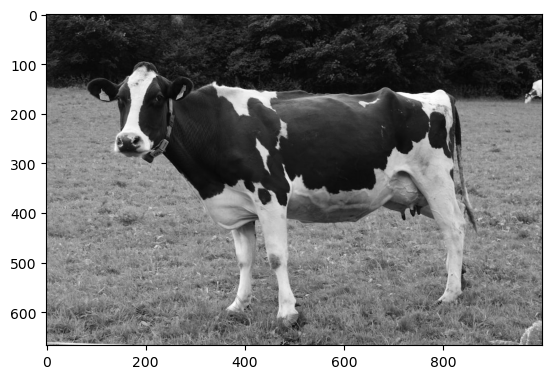

In [14]:
img = I.from_np(plt.imread('data/bg/sapix.jpeg')).image
# img = I.bl_resize(original_img=img, new_h=200, new_w=200)
gray = I.to_gray(img)
I.show(gray, gray=True)

### Edge Detection

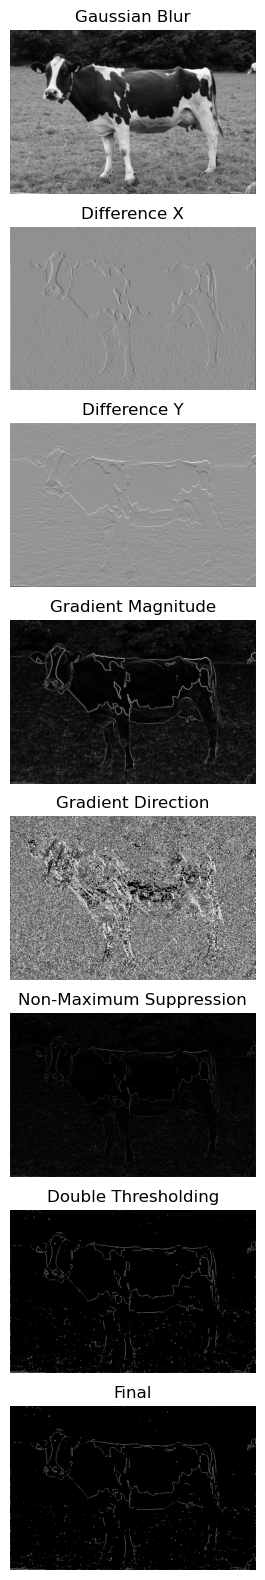

In [15]:
edge = canny_edge_detector(img=img, low=0.65, high=0.7, hyst=False, verbose=True)

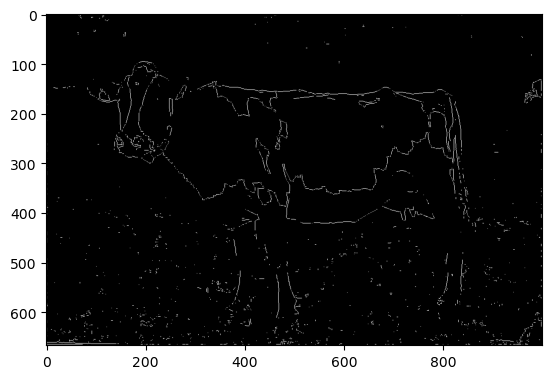

In [16]:
I.show(edge, gray=True)

### Detect Connected Components

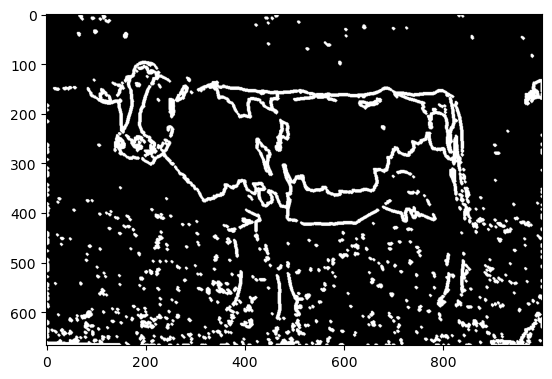

In [17]:
# normalize edges to 0 and 1
norm = [[0 if i == 0 else 1 for i in j] for j in edge]

# dilate
dilated = dilate(norm, kernel=[[0, 1, 0], [1, 1, 1], [0, 1, 0]], k=3)
I.show(dilated, gray=True)

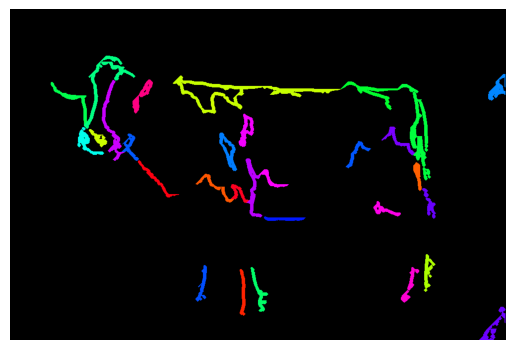

In [18]:
label_matrix, component_sizes, label_dict = connected_components(binary_image=dilated, min_size=500)
plot_label_matrix(label_matrix=label_matrix)

### Connect Disjoint Edges

#### Remove Components Located on the Border

In [19]:
def remove_border_component(label_matrix, thickness=2):
    label_matrix = copy.deepcopy(label_matrix)
    height, width = len(label_matrix), len(label_matrix[0])
    
    top_border, bottom_border, left_border, right_border = [], [], [], []
    # Get borders with thickness
    for i in range(thickness):
        top_border += label_matrix[i]
        bottom_border += label_matrix[-i]
        left_border += [row[i] for row in label_matrix]
        right_border += [row[-i] for row in label_matrix]
    
    borders = [top_border, bottom_border, left_border, right_border]
    
    # Get border labels
    border_labels = set(sum(borders, []))
    # Remove background label
    border_labels.remove(0)
        
    # Remove the components on the border
    for i in range(height):
        for j in range(width):
            if label_matrix[i][j] in border_labels:
                label_matrix[i][j] = 0
                
    return label_matrix

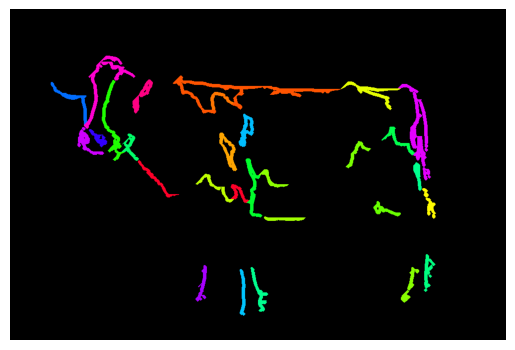

In [20]:
clean_label_matrix = remove_border_component(label_matrix=label_matrix, thickness=10)
plot_label_matrix(label_matrix=clean_label_matrix)

#### Extreme Points

In [21]:
def calculate_extreme_points(label_matrix):
    height, width = len(label_matrix), len(label_matrix[0])
    
    extreme_points = {}
    
    # Iterate through each label
    for i in range(height):
        for j in range(width):
            label = label_matrix[i][j]
            
            try:
                if label != 0:
                    neighbors = [[ label_matrix[i - 1][j - 1], label_matrix[i - 1][j], label_matrix[i - 1][j + 1]],
                                [ label_matrix[i][j - 1], label_matrix[i][j + 1]],
                                [ label_matrix[i + 1][j - 1], label_matrix[i + 1][j], label_matrix[i + 1][j + 1]]]
                    
                    # remove different labels
                    neighbors = [n for row in neighbors for n in row if n != label]
                    
                    # Count the number of neighbors
                    num_neighbors = sum([neighbors.count(n) for n in set(neighbors)])
                    
                    # Check if the label already exists in the dictionary
                    if label not in extreme_points:
                        extreme_points[label] = {
                            'coordinates': [(i, j)],
                            'num_neighbors': num_neighbors
                        }
                    else:
                        # Update the extreme points if necessary
                        if num_neighbors < extreme_points[label]['num_neighbors']:
                            extreme_points[label]['coordinates'] = [(i, j)]
                            extreme_points[label]['num_neighbors'] = num_neighbors
                        elif num_neighbors == extreme_points[label]['num_neighbors']:
                            # Check if the current coordinate is similar to the existing extreme points
                            threshold = 5
                            distinct = True
                            for coordinate in extreme_points[label]['coordinates']:
                                if abs(i - coordinate[0]) <= threshold and abs(j - coordinate[1]) <= threshold:
                                    # If the current coordinate is similar to an existing extreme point, skip
                                    distinct = False
                                    break
                            if distinct:
                                extreme_points[label]['coordinates'].append((i, j))
            except IndexError:
                continue
    
    return extreme_points

In [22]:
extreme_points = calculate_extreme_points(label_matrix=clean_label_matrix)

In [ ]:
extreme_points.keys()
# print length of each extreme points
for key in extreme_points.keys():
    length = len(extreme_points[key]['coordinates'])
    print(f'{key}: {length}')

In [ ]:
for label, info in extreme_points.items():
    coordinates = info['coordinates']
    
    first = coordinates[0]
    last = coordinates[-1]
    mid = coordinates[len(coordinates) // 2]
    quarter = coordinates[len(coordinates) // 4]
    three_quarter = coordinates[len(coordinates) // 4 * 3]
    
    extreme_points[label]['coordinates'] = [first, last, mid, quarter, three_quarter]
    print(f'{label}: {extreme_points[label]["coordinates"]}')

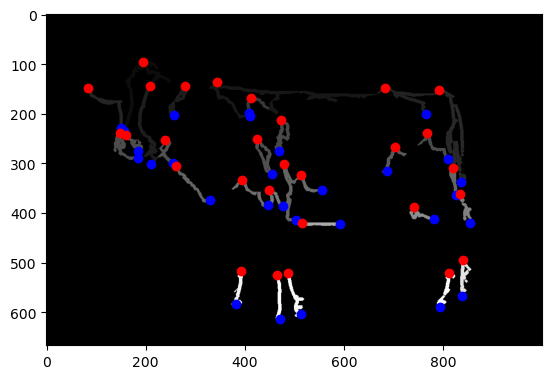

In [25]:
import matplotlib.pyplot as plt

def plot_extreme_points(label_matrix, extreme_points):
    plt.imshow(label_matrix, cmap='gray')  # Display the label matrix
    
    for label, info in extreme_points.items():
        coordinates = info['coordinates']
        plt.scatter(coordinates[0][1], coordinates[0][0], color='red', marker='o')
        plt.scatter(coordinates[1][1], coordinates[1][0], color='blue', marker='o')
        # plt.scatter(coordinates[2][1], coordinates[2][0], color='yellow', marker='o')
        # plt.scatter(coordinates[3][1], coordinates[3][0], color='green', marker='o')
        # plt.scatter(coordinates[4][1], coordinates[4][0], color='purple', marker='o')
    plt.show()

# Assuming you have the label_matrix and extreme_points dictionary
plot_extreme_points(clean_label_matrix, extreme_points)


#### Connect Extreme Points

##### Closest Extreme Points (approach 1)

In [26]:
def calculate_distance(point1: tuple, point2: tuple): # pythagoras theorem
    return ((point1[0] - point2[0]) ** 2 + (point1[1] - point2[1]) ** 2) ** .5

In [27]:
# for each label, calculate the distance of the extreme points to other label's extreme points
distance_matrix = {}
for label1, info1 in extreme_points.items():
    for label2, info2 in extreme_points.items():
        if label1 != label2:
            coordinates1 = info1['coordinates']
            coordinates2 = info2['coordinates']
            
            # get first and last item of each extreme points
            first1 = coordinates1[0]
            last1 = coordinates1[1]
            first2 = coordinates2[0]
            last2 = coordinates2[1]
            
            # distances
            minimum_distance_first = math.inf
            minimum_distance_last = math.inf
            first_points = []
            last_points = []
            
            first_pairs, last_pairs = [(first1, first2), (first1, last2)], [(last1, first2), (last1, last2)]
            
            for pair in first_pairs:
                distance = calculate_distance(pair[0], pair[1])
                if distance < minimum_distance_first:
                    minimum_distance_first = distance
                    first_points = list(pair)
                    
            for pair in last_pairs:
                distance = calculate_distance(pair[0], pair[1])
                if distance < minimum_distance_last:
                    minimum_distance_last = distance
                    last_points = list(pair)
            
            # print(f'{label1} to {label2}: {minimum_distance_first}, {first_points} | {minimum_distance_last}, {last_points}')
            
            if label1 not in distance_matrix:
                distance_matrix[label1] = {
                    'first': {
                        'distance': minimum_distance_first,
                        'points': first_points
                    },
                    'last': {
                        'distance': minimum_distance_last,
                        'points': last_points
                    }
                }
            else:
                if minimum_distance_first < distance_matrix[label1]['first']['distance']:
                    distance_matrix[label1]['first']['distance'] = minimum_distance_first
                    distance_matrix[label1]['first']['points'] = first_points
                if minimum_distance_last < distance_matrix[label1]['last']['distance']:
                    distance_matrix[label1]['last']['distance'] = minimum_distance_last
                    distance_matrix[label1]['last']['points'] = last_points

In [28]:
def draw_line(point1, point2):
    x1, y1 = point1
    x2, y2 = point2

    line_points = []

    # Calculate the distance between the two points
    dx = x2 - x1
    dy = y2 - y1

    # Determine the number of steps (intermediate points) along the line
    num_steps = max(abs(dx), abs(dy))

    # Calculate the step size for each coordinate
    step_x = dx / num_steps
    step_y = dy / num_steps

    # Generate the intermediate points using linear interpolation
    for i in range(num_steps + 1):
        x = x1 + i * step_x
        y = y1 + i * step_y
        line_points.append((round(x), round(y)))

    return line_points

In [29]:
# iterate through the distance matrix and draw the line
connected_lines = []
for label, info in distance_matrix.items():
    first_points = info['first']['points']
    last_points = info['last']['points']
    
    first_line = draw_line(first_points[0], first_points[1])
    last_line = draw_line(last_points[0], last_points[1])
    
    connected_lines.append(first_line)
    connected_lines.append(last_line)

In [30]:
# turn label matrix to binary
binary = copy.deepcopy(clean_label_matrix)
for i in range(len(binary)):
    for j in range(len(binary[0])):
        if binary[i][j] != 0:
            binary[i][j] = 1
# I.show(binary, gray=True)

In [31]:
def plot_connected_lines(label_matrix, connected_lines):
    # plt.imshow(label_matrix, cmap='gray')  # Display the label matrix
    img = copy.deepcopy(label_matrix)
    
    for line in connected_lines:
        # plt.plot([p[1] for p in line], [p[0] for p in line], color='red')
        # apply line to image
        for point in line:
            img[point[0]][point[1]] = 1
            
    plt.imshow(img, cmap='gray')
    
    plt.show()
    
    return img

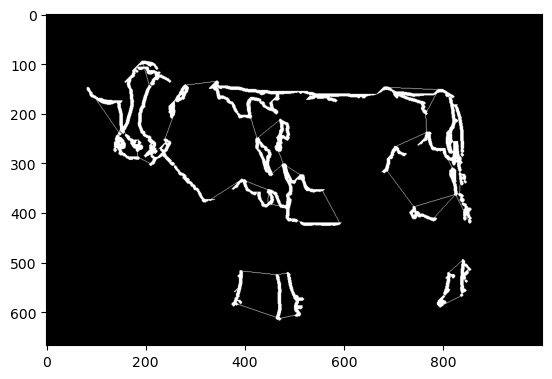

In [32]:
connected = plot_connected_lines(binary, connected_lines=connected_lines)

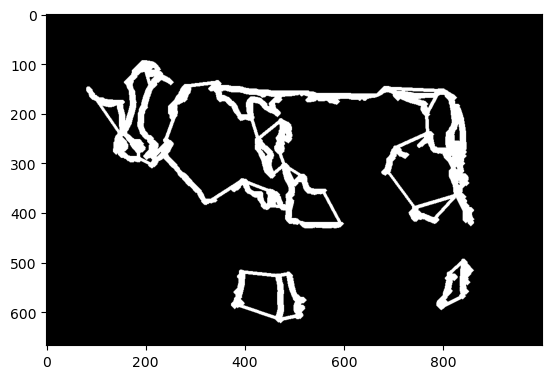

In [33]:
# dilate
connected_dilated = dilate(image=connected, kernel=[[0, 1, 0], [1, 1, 1], [0, 1, 0]], k=3)
I.show(connected_dilated, gray=True)

**Fill Boundaries**

Fill the background, then invert the image. Use or operation to combine the two images.

In [45]:
def flood_fill(image, seed_point, fill_color):
    image = copy.deepcopy(image)
    # Get the dimensions of the image
    height, width = len(image), len(image[0])

    # Get the seed point coordinates
    seed_x, seed_y = seed_point

    # Get the color of the seed point
    target_color = image[seed_y][seed_x]

    # Check if the fill color is the same as the target color
    if fill_color == target_color:
        return
    
    # Create a queue to store the points that need to be checked
    points_to_check = []
    
    # Add the seed point to the queue
    points_to_check.append(seed_point)
    
    # Loop until the queue is empty
    while points_to_check:
        # Get the next point to check
        x, y = points_to_check.pop(0)
        
        # Check if the point is within the image bounds
        if 0 <= x < width and 0 <= y < height:
            # Check if the point has the target color
            if image[y][x] == target_color:
                # Fill the pixel with the fill color
                image[y][x] = fill_color
                
                # Add the neighboring pixels to the queue
                points_to_check.append((x - 1, y))
                points_to_check.append((x + 1, y))
                points_to_check.append((x, y - 1))
                points_to_check.append((x, y + 1))
                
    return image
                
                

In [47]:
def invert(image):
    image = copy.deepcopy(image)
    height, width = len(image), len(image[0])
    
    for i in range(height):
        for j in range(width):
            image[i][j] = 1 - image[i][j]
            
    return image

In [51]:
def combine_binary(image1, image2):
    image1 = copy.deepcopy(image1)
    image2 = copy.deepcopy(image2)
    height, width = len(image1), len(image1[0])
    
    for i in range(height):
        for j in range(width):
            image1[i][j] = max(image1[i][j], image2[i][j])
            
    return image1

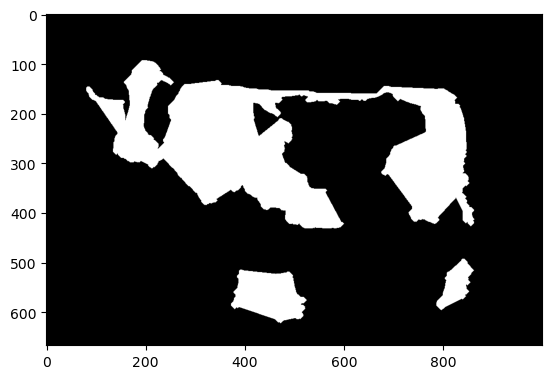

In [53]:
b = flood_fill(image=connected_dilated, seed_point=(0, 0), fill_color=1)
inv = invert(b)

# combine original with inverted background
combined = combine_binary(image1=connected_dilated, image2=inv)

I.show(combined, gray=True)

##### Predict component direction (approach 2)

For each component, we predict the direction of the component by calculating the angle of the line connecting the extreme points. We then use this angle to predict the direction of the component.

**Linear Regression**

$ Y = mX + c $

$ m = \frac{n \sum Y_i X_i  - \sum Y_i \sum X_i}{n\sum Xi^2 - (\sum Xi)^2}$

$ c = \frac{1}{n} \sum Y_i - \frac{1}{n} \sum m X_i$

In [ ]:
def linear_regression(points):
    n = len(points)
    # get x and y
    x = [p[0] for p in points]
    y = [p[1] for p in points]
    
    # calculate sum of y, x, x^2, y * x
    sum_y = sum(y)
    sum_x = sum(x)
    sum_x2 = sum([i ** 2 for i in x])
    sum_yx = sum([i * j for i, j in zip(x, y)])
    
    # calculate m and c
    m = (n * sum_yx - sum_x * sum_y) / (n * sum_x2 - sum_x ** 2)
    c = (sum_y - m * sum_x) / n
    
    return m, c

In [ ]:
def predict_point(m, c, x):
    y = round(m * x + c)
    return (y, x)

In [ ]:
img = copy.deepcopy(binary)
def predict_line(m, c, point, w, h):
    # given points, predict next point, if the next point is not a label, predict the next point again
    # if the next point is a label, stop
    # if the next point is a border, stop and return nothing

    # get the first point
    first_point = point
    predictions = [first_point]
    while True:        
        # predict next point
        next_point = predict_point(m, c, predictions[-1][0])
        predictions.append(next_point)        
        
        # if predicted point is the same as before, stop
        if next_point == predictions[-2]:
            return None
        
        try:
            # check if the next point is a border
            if next_point[0] <= 0 or next_point[0] >= h or next_point[1] <= 0 or next_point[1] >= w:
                return None
        
            # check if the next point or point surrounding it is a label
            neighbors = [
                (next_point[0] - 1, next_point[1] - 1),
                (next_point[0] - 1, next_point[1]),
                (next_point[0] - 1, next_point[1] + 1),
                (next_point[0], next_point[1] - 1),
                (next_point[0], next_point[1] + 1),
                (next_point[0] + 1, next_point[1] - 1),
                (next_point[0] + 1, next_point[1]),
                (next_point[0] + 1, next_point[1] + 1),
            ]
            
            if label_matrix[next_point[0]][next_point[1]] != 0:
                break
            
            for neighbor in neighbors:
                if label_matrix[neighbor[0]][neighbor[1]] != 0:
                    break
            
            
        except IndexError:
            return None
        
    
    return predictions
    

In [ ]:
# iterate through the extreme points and predict lines
def get_lines(binary_img, extreme_points):
    h, w = len(binary_img), len(binary_img[0])
    
    predicted_lines = []
    for label, info in extreme_points.items():
        line_points = []
        coordinates = info['coordinates']
        
        # get the m and c
        m, c = linear_regression(coordinates)
        
        # predict the line
        predicted_line = predict_line(m, c, coordinates[0], w, h)
        if predicted_line is not None:
            predicted_lines.append(predicted_line)
            
    return predicted_lines

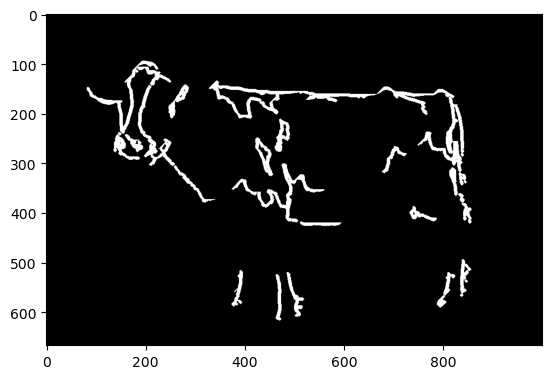

In [ ]:
predicted_lines = get_lines(binary, extreme_points)
I.show(img, gray=True)

In [ ]:
# plot the predicted lines
predicted_lines = get_lines(binary, extreme_points)

predicted_lines

[]